In the previous notebook, we changed the metric for Kmeans and ran it through networks of increasing density and found, that only dot similarity performed significantly worse. The convergence problem was somewhat avoided by using Kmeans++ initialization for the centroids so that we can avoid.

In [1]:
'''
Writing this script such that if I run it with input parameters, 
it should give me element centric similarity for the methods, we query
each method we query can run withinn this or out. Will decide.
Use chanage_mu_test.py as reference.
'''
import numpy as np
from scipy import sparse
import pandas as pd
#import os
#import networkx as nx
#import gensim
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.linear_model import LogisticRegression 
import faiss
import fast_hdbscan
#import lfr
#import embcom
#import csv
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
#from scripts.clustering_methods import clustering_method_values
from scripts.nets_and_embeddings import load_net_and_embedding

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
import numpy as np
import belief_propagation
import infomap
from graph_tool.all import Graph,minimize_blockmodel_dl

# Need net, node_table and emb files
# net is G, emb files are wv, node_table probably
# has some info about ground truth community labels or smth like that.

# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

In [2]:


def louvain(Z, w1, b0, num_neighbors=100, iteration=50, device="cuda:0", return_member_matrix=False, metric="dotsim"):
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()

    while True:
        cids_t = label_switching(
            Z=Vt,
            num_neighbors=num_neighbors,
            rho=b0 / w1,
            node_size=node_size,
            epochs=iteration,
            device=device,
            metric=metric
        )
        _, cids_t = np.unique(cids_t, return_inverse=True)

        if int(max(cids_t) + 1) == Vt.shape[0]:
            break

        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        node_size = np.array(Ut.T @ node_size).reshape(-1)

    if return_member_matrix:
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)
    return cids
import faiss
import numpy as np
from scipy import sparse
from sklearn.linear_model import LogisticRegression

def find_knn_edges(emb, num_neighbors, target=None, metric="dotsim", device=None):
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    # Normalize embeddings if metric is cosine
    if metric == "cosine":
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
        if target is not None:
            target = target / np.linalg.norm(target, axis=1, keepdims=True)

    indices, distances = find_knn(
        emb if target is None else target, emb, num_neighbors=k, metric=metric, device=device
    )
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = r.reshape(-1), indices.astype(int).reshape(-1), distances.reshape(-1)
    if len(r) == 0:
        return r, c, distances
    return r, c, distances


def find_knn(target, emb, num_neighbors, metric="dotsim", device=None):
    if metric == "dotsim" or metric == "cosine":
        index = faiss.IndexFlatIP(emb.shape[1])
        if metric == "cosine":
            emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            target = target / np.linalg.norm(target, axis=1, keepdims=True)
    elif metric == "euclidean":
        index = faiss.IndexFlatL2(emb.shape[1])
    elif metric == "manhattan":
        index = faiss.IndexFlatL1(emb.shape[1]) # THIS DOES NOT EXIST, CAN'T DO INDEXING FOR MANHATTAN I GUESS
    else:
        raise ValueError("Invalid metric specified.")

    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
    else:
        gpu_id = int(device[-1])
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, gpu_id, index)
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        index.reset()

    return indices, distances


def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None, epochs=50, metric="dotsim"):
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)

    # Normalize Z for cosine similarity without adding extra dimensions
    if metric == "cosine":
        Z1 = Z / np.linalg.norm(Z, axis=1, keepdims=True)
        Zrho = Z1  # Use the normalized Z1 directly without adding extra dimensions
    else:
        Z1 = Z
        Zrho = Z

    # Perform nearest neighbor search with consistent dimensions
    r, c, v = find_knn_edges(Zrho, target=Z1, num_neighbors=num_neighbors, metric=metric, device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))

    return _label_switching_(A.indptr, A.indices, Z, num_nodes, rho, node_size, epochs, metric=metric)

    
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size, epochs=100, metric="dotsim"):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()

    if metric in ["dotsim", "cosine"]:
        Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1)

    for nid in range(num_nodes):
        Nc[nid] += node_size[nid]

    for _ in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False)
        updated_node_num = 0

        for node_id in order:
            neighbors = A_indices[A_indptr[node_id]:A_indptr[node_id + 1]]
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1

            if metric == "euclidean":
                dqmin = float("inf")
                qself = np.sum((Z[node_id, :] - Vc[c, :]) ** 2) + rho * node_size[node_id] * (Nc[c] - node_size[node_id])
            elif metric == "manhattan":
                dqmin = float("inf")
                qself = np.sum(np.abs(Z[node_id, :] - Vc[c, :])) + rho * node_size[node_id] * (Nc[c] - node_size[node_id])
            else:  # dotsim or cosine
                dqmax = 0
                qself = np.sum(Z[node_id, :] * Vc[c, :]) - Vnorm[node_id] - rho * node_size[node_id] * (Nc[c] - node_size[node_id])

            for cprime in clist:
                if c == cprime:
                    continue

                if metric == "euclidean":
                    dq = np.sum((Z[node_id, :] - Vc[cprime, :]) ** 2) + rho * node_size[node_id] * Nc[cprime] - qself
                    if dq < dqmin:
                        next_cid = cprime
                        dqmin = dq
                elif metric == "manhattan":
                    dq = np.sum(np.abs(Z[node_id, :] - Vc[cprime, :])) + rho * node_size[node_id] * Nc[cprime] - qself
                    if dq < dqmin:
                        next_cid = cprime
                        dqmin = dq
                else:  # dotsim or cosine
                    dq = (np.sum(Z[node_id, :] * Vc[cprime, :]) - rho * node_size[node_id] * Nc[cprime]) - qself
                    if dq > dqmax:
                        next_cid = cprime
                        dqmax = dq

            if (metric in ["euclidean", "manhattan"] and dqmin >= 0) or (metric in ["dotsim", "cosine"] and dqmax <= 1e-16):
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / max(1, num_nodes)) < 1e-3:
            break

    return cids


def proposed_method_labels(emb, device_name, metric="dotsim"):
    if metric == "cosine":
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=500, device=device_name, metric=metric)
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
    )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0]
    return louvain(emb, w1, b0, device=device_name, metric=metric)


def clustering_method_values(net, community_table, emb, score_keys, device_name):
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()

    def method_score(key):
        if key == "proposed_euclidean":
            return calc_esim(community_table["community_id"], proposed_method_labels(emb, device_name, metric="euclidean"))
        elif key == "proposed_cosine":
            return calc_esim(community_table["community_id"], proposed_method_labels(emb, device_name, metric="cosine"))
        elif key == "proposed_dot":
            return calc_esim(community_table["community_id"], proposed_method_labels(emb, device_name, metric="dotsim"))
        elif key == "proposed_manhattan":
            return calc_esim(community_table["community_id"], proposed_method_labels(emb, device_name, metric="manhattan"))

    score_dictionary = {key: method_score(key) for key in score_keys}
    return score_dictionary




In [3]:
import faiss
faiss.__version__

'1.7.3'

In [4]:
N=10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05),decimals=2)

params = {
    "N": N,
    "k": 50,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.1,
    }


emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

run_no = 1
path_name= f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/Run_{run_no}/"

#"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_0.1_k_50_mincomm_50.npz"

net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

# The default for alt_means is using cosine sim for finding knn using FAISS
# And the louvain update scheme uses dot sim update scheme.
# First steps could be to just change louvain update scheme, as FAISS to euclidean could be very slow?



In [11]:
t1 = time.time()

print(clustering_method_values(net, community_table, emb, score_keys, device_name = "cuda:0"))
print(time.time()-t1)

{'proposed_cosine': 1.0, 'proposed_dot': 1.0}
31.06645941734314


{'proposed_euclidean': 0.0032003200320032013,
 'proposed_cosine': 0.9962968577863731,
 'proposed_dot': 1.0}

In [7]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import time


N=10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05),decimals=2)
score_keys=['proposed_cosine','proposed_dot'] 

params_template = {
    "N": N,
    "k": 50,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.1,
    }


emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

 
#"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_0.1_k_50_mincomm_50.npz"

 
# The default for alt_means is using cosine sim for finding knn using FAISS
# And the louvain update scheme uses dot sim update scheme.
# First steps could be to just change louvain update scheme, as FAISS to euclidean could be very slow?



def process_run(run_no, mu):
    # Enforce the specific GPU device within each process if you have multiple GPUs
#    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Change if you want to specify another GPU

    params = params_template.copy()
    params["mu"] = mu

    path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/Run_{run_no}/"
    net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

    # Compute clustering scores
    result = clustering_method_values(net, community_table, emb, score_keys, device_name="cuda:0")

    result_values = [result[key] for key in score_keys]
    result_str = f"{run_no},{mu}," + ",".join(map(str, result_values))
    print(f"Completed Run {run_no} with Mu {mu} with esim {result_str}")
    return result_str
    
from tqdm import tqdm
import time

def process_all_combinations_sequential():
    runs_mu_combinations = [(run_no, mu) for run_no in range(1, 11) for mu in mu_values]
    total_combinations = len(runs_mu_combinations)
    start_time = time.time()
    output_file = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/altmeans_clustering_metric_change.txt"
    # Write header to output file
    with open(output_file, "w") as f:
        header = "run_no,mu," + ",".join(score_keys) + "\n"
        f.write(header)

    # Sequentially process each run and mu value with tqdm for progress tracking
    with open(output_file, "a") as f:
        for (run_no, mu) in tqdm(runs_mu_combinations, desc="Processing runs", total=total_combinations):
            try:
                result_str = process_run(run_no, mu)
                f.write(result_str + "\n")
                f.flush()  # Ensures each line is written immediately
            except Exception as e:
                print(f"Error processing Run {run_no}, Mu {mu}: {e}")
    
    print(f"All combinations processed. Total elapsed time: {time.time() - start_time:.2f} seconds.")

# Run the sequential processing
if __name__ == "__main__":
    

    process_all_combinations_sequential()


Processing runs:   0%|▌                                                                                                                   | 1/200 [00:32<1:46:51, 32.22s/it]

Completed Run 1 with Mu 0.05 with esim 1,0.05,1.0,0.9993851409638217


Processing runs:   1%|█▏                                                                                                                  | 2/200 [01:03<1:44:33, 31.68s/it]

Completed Run 1 with Mu 0.1 with esim 1,0.1,1.0,1.0


Processing runs:   2%|█▋                                                                                                                  | 3/200 [03:00<3:51:22, 70.47s/it]

Completed Run 1 with Mu 0.15 with esim 1,0.15,0.9995790577878313,1.0


Processing runs:   2%|██▎                                                                                                                | 4/200 [05:43<5:50:13, 107.21s/it]

Completed Run 1 with Mu 0.2 with esim 1,0.2,0.9991637870265448,1.0


Processing runs:   2%|██▉                                                                                                                | 5/200 [08:00<6:22:53, 117.81s/it]

Completed Run 1 with Mu 0.25 with esim 1,0.25,0.9983514559748025,1.0


Processing runs:   3%|███▍                                                                                                               | 6/200 [10:22<6:48:06, 126.22s/it]

Completed Run 1 with Mu 0.3 with esim 1,0.3,0.9981540549521527,1.0


Processing runs:   4%|████                                                                                                               | 7/200 [12:36<6:54:16, 128.79s/it]

Completed Run 1 with Mu 0.35 with esim 1,0.35,0.9936076569820308,0.9982476910184013


Processing runs:   4%|████▌                                                                                                              | 8/200 [14:41<6:48:13, 127.57s/it]

Completed Run 1 with Mu 0.4 with esim 1,0.4,0.9962968577863731,1.0


Processing runs:   4%|█████▏                                                                                                             | 9/200 [16:52<6:49:31, 128.65s/it]

Completed Run 1 with Mu 0.45 with esim 1,0.45,0.9786050181934214,0.9696411982443885


Processing runs:   5%|█████▋                                                                                                            | 10/200 [18:58<6:44:37, 127.78s/it]

Completed Run 1 with Mu 0.5 with esim 1,0.5,0.9858801873973094,0.899265899837218


Processing runs:   6%|██████▎                                                                                                           | 11/200 [21:09<6:45:12, 128.64s/it]

Completed Run 1 with Mu 0.55 with esim 1,0.55,0.9854544514905853,0.8293959597880809


Processing runs:   6%|██████▊                                                                                                           | 12/200 [23:18<6:43:38, 128.82s/it]

Completed Run 1 with Mu 0.6 with esim 1,0.6,0.9587638479418843,0.7718541991641407


Processing runs:   6%|███████▍                                                                                                          | 13/200 [24:02<5:21:48, 103.25s/it]

Completed Run 1 with Mu 0.65 with esim 1,0.65,0.8194690305789942,0.6770780135427843


Processing runs:   7%|████████                                                                                                           | 14/200 [25:03<4:40:07, 90.36s/it]

Completed Run 1 with Mu 0.7 with esim 1,0.7,0.5472811156902315,0.4172511430709448


Processing runs:   8%|████████▋                                                                                                          | 15/200 [26:36<4:40:55, 91.11s/it]

Completed Run 1 with Mu 0.75 with esim 1,0.75,0.2732536021801351,0.3165223342779847


Processing runs:   8%|█████████                                                                                                         | 16/200 [29:19<5:46:12, 112.89s/it]

Completed Run 1 with Mu 0.8 with esim 1,0.8,0.096767919013667,0.15673260826035718


Processing runs:   8%|█████████▋                                                                                                        | 17/200 [33:50<8:08:37, 160.21s/it]

Completed Run 1 with Mu 0.85 with esim 1,0.85,0.003431777817638355,0.01603047976506815


Processing runs:   9%|██████████▎                                                                                                       | 18/200 [38:11<9:38:30, 190.72s/it]

Completed Run 1 with Mu 0.9 with esim 1,0.9,0.0026747664144139687,0.0037758195225640135


Processing runs:  10%|██████████▊                                                                                                       | 19/200 [41:48<9:59:00, 198.56s/it]

Completed Run 1 with Mu 0.95 with esim 1,0.95,0.0018700231487646345,0.0036179145559549312


Processing runs:  10%|███████████▍                                                                                                      | 20/200 [45:09<9:57:57, 199.32s/it]

Completed Run 1 with Mu 1.0 with esim 1,1.0,0.002499417624256135,0.0034002411321958532


Processing runs:  10%|███████████▉                                                                                                      | 21/200 [45:42<7:25:04, 149.19s/it]

Completed Run 2 with Mu 0.05 with esim 2,0.05,1.0,0.999383568764299


Processing runs:  11%|████████████▌                                                                                                     | 22/200 [46:13<5:38:02, 113.94s/it]

Completed Run 2 with Mu 0.1 with esim 2,0.1,1.0,1.0


Processing runs:  12%|█████████████▏                                                                                                     | 23/200 [46:45<4:23:23, 89.29s/it]

Completed Run 2 with Mu 0.15 with esim 2,0.15,1.0,1.0


Processing runs:  12%|█████████████▊                                                                                                     | 24/200 [47:16<3:30:54, 71.90s/it]

Completed Run 2 with Mu 0.2 with esim 2,0.2,0.9985569385229561,0.9993823442629426


Processing runs:  12%|██████████████▍                                                                                                    | 25/200 [47:49<2:55:07, 60.04s/it]

Completed Run 2 with Mu 0.25 with esim 2,0.25,0.9981470698913,0.9938350914949703


Processing runs:  13%|██████████████▉                                                                                                    | 26/200 [48:20<2:28:51, 51.33s/it]

Completed Run 2 with Mu 0.3 with esim 2,0.3,0.9954512012149473,1.0


Processing runs:  14%|███████████████▌                                                                                                   | 27/200 [48:51<2:10:45, 45.35s/it]

Completed Run 2 with Mu 0.35 with esim 2,0.35,0.9904728027244099,0.9996888524432284


Processing runs:  14%|████████████████                                                                                                   | 28/200 [49:23<1:58:01, 41.17s/it]

Completed Run 2 with Mu 0.4 with esim 2,0.4,0.9927865755311873,0.9890900540760318


Processing runs:  14%|████████████████▋                                                                                                  | 29/200 [49:54<1:48:42, 38.14s/it]

Completed Run 2 with Mu 0.45 with esim 2,0.45,0.994492105086754,0.960755800828939


Processing runs:  15%|█████████████████▎                                                                                                 | 30/200 [50:26<1:43:06, 36.39s/it]

Completed Run 2 with Mu 0.5 with esim 2,0.5,0.9833287900537909,0.9349475459627294


Processing runs:  16%|█████████████████▊                                                                                                 | 31/200 [51:00<1:40:16, 35.60s/it]

Completed Run 2 with Mu 0.55 with esim 2,0.55,0.9909197062971792,0.8759247424298228


Processing runs:  16%|██████████████████▍                                                                                                | 32/200 [51:35<1:39:45, 35.63s/it]

Completed Run 2 with Mu 0.6 with esim 2,0.6,0.976903476475361,0.8652530787080203


Processing runs:  16%|██████████████████▉                                                                                                | 33/200 [52:18<1:45:19, 37.84s/it]

Completed Run 2 with Mu 0.65 with esim 2,0.65,0.8763970340346049,0.6271292789827565


Processing runs:  17%|███████████████████▌                                                                                               | 34/200 [53:25<2:08:19, 46.38s/it]

Completed Run 2 with Mu 0.7 with esim 2,0.7,0.4031105645486764,0.3382239707352977


Processing runs:  18%|████████████████████▏                                                                                              | 35/200 [54:42<2:33:11, 55.71s/it]

Completed Run 2 with Mu 0.75 with esim 2,0.75,0.40197285293215573,0.3999617801815747


Processing runs:  18%|████████████████████▋                                                                                              | 36/200 [57:42<4:13:33, 92.77s/it]

Completed Run 2 with Mu 0.8 with esim 2,0.8,0.03603821425199578,0.09666249887465433


Processing runs:  18%|████████████████████▋                                                                                           | 37/200 [1:01:25<5:58:27, 131.95s/it]

Completed Run 2 with Mu 0.85 with esim 2,0.85,0.0039375308337459836,0.016201993979258984


Processing runs:  19%|█████████████████████▎                                                                                          | 38/200 [1:07:08<8:47:38, 195.42s/it]

Completed Run 2 with Mu 0.9 with esim 2,0.9,0.0021875547475658057,0.0029311131266849867


Processing runs:  20%|█████████████████████▊                                                                                          | 39/200 [1:11:33<9:40:22, 216.29s/it]

Completed Run 2 with Mu 0.95 with esim 2,0.95,0.00270822612588632,0.003562252633998705


Processing runs:  20%|██████████████████████▏                                                                                        | 40/200 [1:16:53<10:59:11, 247.19s/it]

Completed Run 2 with Mu 1.0 with esim 2,1.0,0.003304683479353381,0.0035808173506264775


Processing runs:  20%|██████████████████████▉                                                                                         | 41/200 [1:17:26<8:04:57, 183.00s/it]

Completed Run 3 with Mu 0.05 with esim 3,0.05,1.0,1.0


Processing runs:  21%|███████████████████████▌                                                                                        | 42/200 [1:17:59<6:03:13, 137.93s/it]

Completed Run 3 with Mu 0.1 with esim 3,0.1,1.0,0.9938069928488745


Processing runs:  22%|████████████████████████                                                                                        | 43/200 [1:18:30<4:36:54, 105.83s/it]

Completed Run 3 with Mu 0.15 with esim 3,0.15,1.0,1.0


Processing runs:  22%|████████████████████████▊                                                                                        | 44/200 [1:19:01<3:37:25, 83.63s/it]

Completed Run 3 with Mu 0.2 with esim 3,0.2,1.0,1.0


Processing runs:  22%|█████████████████████████▍                                                                                       | 45/200 [1:19:33<2:55:40, 68.00s/it]

Completed Run 3 with Mu 0.25 with esim 3,0.25,0.9977173361854128,1.0


Processing runs:  23%|█████████████████████████▉                                                                                       | 46/200 [1:20:05<2:26:55, 57.24s/it]

Completed Run 3 with Mu 0.3 with esim 3,0.3,0.998561017596093,0.9985637017510162


Processing runs:  24%|██████████████████████████▌                                                                                      | 47/200 [1:20:36<2:06:05, 49.45s/it]

Completed Run 3 with Mu 0.35 with esim 3,0.35,0.9938346745012694,0.9990737008739888


Processing runs:  24%|███████████████████████████                                                                                      | 48/200 [1:21:08<1:51:41, 44.09s/it]

Completed Run 3 with Mu 0.4 with esim 3,0.4,0.9948766674971143,0.9858258093472314


Processing runs:  24%|███████████████████████████▋                                                                                     | 49/200 [1:21:40<1:41:32, 40.35s/it]

Completed Run 3 with Mu 0.45 with esim 3,0.45,0.9834095435432494,0.9732850840130941


Processing runs:  25%|████████████████████████████▎                                                                                    | 50/200 [1:22:11<1:34:26, 37.78s/it]

Completed Run 3 with Mu 0.5 with esim 3,0.5,0.9839628553181077,0.9406993937911758


Processing runs:  26%|████████████████████████████▊                                                                                    | 51/200 [1:22:46<1:31:15, 36.75s/it]

Completed Run 3 with Mu 0.55 with esim 3,0.55,0.9822758111322483,0.8616480303895163


Processing runs:  26%|█████████████████████████████▍                                                                                   | 52/200 [1:23:22<1:30:04, 36.52s/it]

Completed Run 3 with Mu 0.6 with esim 3,0.6,0.9395313056438818,0.8480966742501627


Processing runs:  26%|█████████████████████████████▉                                                                                   | 53/200 [1:24:01<1:31:30, 37.35s/it]

Completed Run 3 with Mu 0.65 with esim 3,0.65,0.942329564946541,0.682225805576285


Processing runs:  27%|██████████████████████████████▌                                                                                  | 54/200 [1:24:49<1:38:33, 40.50s/it]

Completed Run 3 with Mu 0.7 with esim 3,0.7,0.7882786800923198,0.5779561652182078


Processing runs:  28%|███████████████████████████████                                                                                  | 55/200 [1:26:09<2:06:29, 52.34s/it]

Completed Run 3 with Mu 0.75 with esim 3,0.75,0.33910984148268497,0.34643081068687703


Processing runs:  28%|███████████████████████████████▋                                                                                 | 56/200 [1:28:35<3:13:28, 80.61s/it]

Completed Run 3 with Mu 0.8 with esim 3,0.8,0.08223985174664446,0.13864014262516444


Processing runs:  28%|███████████████████████████████▉                                                                                | 57/200 [1:32:20<4:55:14, 123.88s/it]

Completed Run 3 with Mu 0.85 with esim 3,0.85,0.004526750648221037,0.01538109749327688


Processing runs:  29%|████████████████████████████████▍                                                                               | 58/200 [1:37:50<7:19:03, 185.51s/it]

Completed Run 3 with Mu 0.9 with esim 3,0.9,0.0021508832788608243,0.003325118974290168


Processing runs:  30%|█████████████████████████████████                                                                               | 59/200 [1:41:43<7:49:43, 199.89s/it]

Completed Run 3 with Mu 0.95 with esim 3,0.95,0.002517314347878647,0.0036955395084934763


Processing runs:  30%|█████████████████████████████████▌                                                                              | 60/200 [1:45:40<8:12:43, 211.17s/it]

Completed Run 3 with Mu 1.0 with esim 3,1.0,0.0029427105233324593,0.003431995240828973


Processing runs:  30%|██████████████████████████████████▏                                                                             | 61/200 [1:46:13<6:05:15, 157.66s/it]

Completed Run 4 with Mu 0.05 with esim 4,0.05,1.0,1.0


Processing runs:  31%|██████████████████████████████████▋                                                                             | 62/200 [1:46:45<4:35:34, 119.81s/it]

Completed Run 4 with Mu 0.1 with esim 4,0.1,1.0,1.0


Processing runs:  32%|███████████████████████████████████▌                                                                             | 63/200 [1:47:16<3:33:11, 93.37s/it]

Completed Run 4 with Mu 0.15 with esim 4,0.15,1.0,0.9923790608866544


Processing runs:  32%|████████████████████████████████████▏                                                                            | 64/200 [1:47:48<2:49:46, 74.90s/it]

Completed Run 4 with Mu 0.2 with esim 4,0.2,1.0,0.9939870791192753


Processing runs:  32%|████████████████████████████████████▋                                                                            | 65/200 [1:48:20<2:19:18, 61.91s/it]

Completed Run 4 with Mu 0.25 with esim 4,0.25,0.9975137904851831,0.9996897540031717


Processing runs:  33%|█████████████████████████████████████▎                                                                           | 66/200 [1:48:51<1:57:40, 52.69s/it]

Completed Run 4 with Mu 0.3 with esim 4,0.3,0.9916521558313376,1.0


Processing runs:  34%|█████████████████████████████████████▊                                                                           | 67/200 [1:49:22<1:42:23, 46.19s/it]

Completed Run 4 with Mu 0.35 with esim 4,0.35,0.9927695413815909,0.9996884428361449


Processing runs:  34%|██████████████████████████████████████▍                                                                          | 68/200 [1:49:54<1:32:01, 41.83s/it]

Completed Run 4 with Mu 0.4 with esim 4,0.4,0.9923720743215728,0.9825751325032441


Processing runs:  34%|██████████████████████████████████████▉                                                                          | 69/200 [1:50:24<1:24:02, 38.49s/it]

Completed Run 4 with Mu 0.45 with esim 4,0.45,0.9963160738186866,0.9987691269623568


Processing runs:  35%|███████████████████████████████████████▌                                                                         | 70/200 [1:50:56<1:19:03, 36.49s/it]

Completed Run 4 with Mu 0.5 with esim 4,0.5,0.9885023490276372,0.9751505363929586


Processing runs:  36%|████████████████████████████████████████                                                                         | 71/200 [1:51:30<1:16:47, 35.72s/it]

Completed Run 4 with Mu 0.55 with esim 4,0.55,0.9761749013407562,0.8815611274839572


Processing runs:  36%|████████████████████████████████████████▋                                                                        | 72/200 [1:52:11<1:19:42, 37.36s/it]

Completed Run 4 with Mu 0.6 with esim 4,0.6,0.9687865909701839,0.8230805669963096


Processing runs:  36%|█████████████████████████████████████████▏                                                                       | 73/200 [1:52:51<1:20:36, 38.08s/it]

Completed Run 4 with Mu 0.65 with esim 4,0.65,0.914891534612455,0.6311397631530553


Processing runs:  37%|█████████████████████████████████████████▊                                                                       | 74/200 [1:54:17<1:50:05, 52.42s/it]

Completed Run 4 with Mu 0.7 with esim 4,0.7,0.4469235092090621,0.4112718469461307


Processing runs:  38%|██████████████████████████████████████████▍                                                                      | 75/200 [1:55:27<1:59:59, 57.60s/it]

Completed Run 4 with Mu 0.75 with esim 4,0.75,0.35593272976376955,0.3937334697111077


Processing runs:  38%|██████████████████████████████████████████▉                                                                      | 76/200 [1:58:16<3:08:03, 90.99s/it]

Completed Run 4 with Mu 0.8 with esim 4,0.8,0.056953603665291314,0.0961530595085631


Processing runs:  38%|███████████████████████████████████████████                                                                     | 77/200 [2:02:59<5:05:08, 148.85s/it]

Completed Run 4 with Mu 0.85 with esim 4,0.85,0.0038742272800289623,0.0138693821249144


Processing runs:  39%|███████████████████████████████████████████▋                                                                    | 78/200 [2:07:33<6:18:34, 186.18s/it]

Completed Run 4 with Mu 0.9 with esim 4,0.9,0.0028727969026293492,0.0040782376228502715


Processing runs:  40%|████████████████████████████████████████████▏                                                                   | 79/200 [2:11:14<6:36:28, 196.60s/it]

Completed Run 4 with Mu 0.95 with esim 4,0.95,0.002396893172726105,0.003523287325359144


Processing runs:  40%|████████████████████████████████████████████▊                                                                   | 80/200 [2:16:14<7:35:41, 227.85s/it]

Completed Run 4 with Mu 1.0 with esim 4,1.0,0.0022130504930844637,0.0028266992452756273


Processing runs:  40%|█████████████████████████████████████████████▎                                                                  | 81/200 [2:16:47<5:35:40, 169.25s/it]

Completed Run 5 with Mu 0.05 with esim 5,0.05,1.0,1.0


Processing runs:  41%|█████████████████████████████████████████████▉                                                                  | 82/200 [2:17:21<4:13:00, 128.64s/it]

Completed Run 5 with Mu 0.1 with esim 5,0.1,0.9974519360762477,0.9987261946174979


Processing runs:  42%|██████████████████████████████████████████████▉                                                                  | 83/200 [2:17:53<3:14:18, 99.64s/it]

Completed Run 5 with Mu 0.15 with esim 5,0.15,1.0,1.0


Processing runs:  42%|███████████████████████████████████████████████▍                                                                 | 84/200 [2:18:24<2:33:03, 79.17s/it]

Completed Run 5 with Mu 0.2 with esim 5,0.2,1.0,1.0


Processing runs:  42%|████████████████████████████████████████████████                                                                 | 85/200 [2:18:56<2:04:36, 65.01s/it]

Completed Run 5 with Mu 0.25 with esim 5,0.25,0.9966838569902086,0.9935478308270602


Processing runs:  43%|████████████████████████████████████████████████▌                                                                | 86/200 [2:19:28<1:44:38, 55.07s/it]

Completed Run 5 with Mu 0.3 with esim 5,0.3,0.9991761740040211,1.0


Processing runs:  44%|█████████████████████████████████████████████████▏                                                               | 87/200 [2:20:00<1:30:24, 48.00s/it]

Completed Run 5 with Mu 0.35 with esim 5,0.35,0.9876935046446965,0.9990639602697317


Processing runs:  44%|█████████████████████████████████████████████████▋                                                               | 88/200 [2:20:31<1:20:31, 43.14s/it]

Completed Run 5 with Mu 0.4 with esim 5,0.4,0.9923848953408421,0.9877874856262366


Processing runs:  44%|██████████████████████████████████████████████████▎                                                              | 89/200 [2:21:03<1:13:30, 39.73s/it]

Completed Run 5 with Mu 0.45 with esim 5,0.45,0.9952862658176556,0.9540659569066996


Processing runs:  45%|██████████████████████████████████████████████████▊                                                              | 90/200 [2:21:36<1:08:56, 37.61s/it]

Completed Run 5 with Mu 0.5 with esim 5,0.5,0.9697301995060128,0.9494346483601992


Processing runs:  46%|███████████████████████████████████████████████████▍                                                             | 91/200 [2:22:09<1:05:49, 36.23s/it]

Completed Run 5 with Mu 0.55 with esim 5,0.55,0.9878219585830218,0.8851446398582344


Processing runs:  46%|███████████████████████████████████████████████████▉                                                             | 92/200 [2:22:47<1:06:31, 36.96s/it]

Completed Run 5 with Mu 0.6 with esim 5,0.6,0.9729899622775122,0.7626803739966447


Processing runs:  46%|████████████████████████████████████████████████████▌                                                            | 93/200 [2:23:28<1:07:49, 38.04s/it]

Completed Run 5 with Mu 0.65 with esim 5,0.65,0.8784753448295763,0.5825675013531866


Processing runs:  47%|█████████████████████████████████████████████████████                                                            | 94/200 [2:24:19<1:14:10, 41.99s/it]

Completed Run 5 with Mu 0.7 with esim 5,0.7,0.6738799666123708,0.5219482911437848


Processing runs:  48%|█████████████████████████████████████████████████████▋                                                           | 95/200 [2:25:31<1:28:56, 50.83s/it]

Completed Run 5 with Mu 0.75 with esim 5,0.75,0.37053495808816284,0.374633617273793


Processing runs:  48%|██████████████████████████████████████████████████████▏                                                          | 96/200 [2:28:32<2:36:07, 90.08s/it]

Completed Run 5 with Mu 0.8 with esim 5,0.8,0.026835937214583484,0.07305433556545411


Processing runs:  48%|██████████████████████████████████████████████████████▎                                                         | 97/200 [2:33:19<4:15:50, 149.04s/it]

Completed Run 5 with Mu 0.85 with esim 5,0.85,0.006956966438909575,0.017803031765330574


Processing runs:  49%|██████████████████████████████████████████████████████▉                                                         | 98/200 [2:37:09<4:54:28, 173.22s/it]

Completed Run 5 with Mu 0.9 with esim 5,0.9,0.002471972764158528,0.003920953936307377


Processing runs:  50%|███████████████████████████████████████████████████████▍                                                        | 99/200 [2:41:25<5:33:26, 198.08s/it]

Completed Run 5 with Mu 0.95 with esim 5,0.95,0.002100187162187342,0.003098599327498306


Processing runs:  50%|███████████████████████████████████████████████████████▌                                                       | 100/200 [2:46:35<6:26:10, 231.71s/it]

Completed Run 5 with Mu 1.0 with esim 5,1.0,0.0024946836105166864,0.0028148318642978952


Processing runs:  50%|████████████████████████████████████████████████████████                                                       | 101/200 [2:47:08<4:43:50, 172.03s/it]

Completed Run 6 with Mu 0.05 with esim 6,0.05,1.0,0.9849628612319559


Processing runs:  51%|████████████████████████████████████████████████████████▌                                                      | 102/200 [2:47:39<3:32:10, 129.91s/it]

Completed Run 6 with Mu 0.1 with esim 6,0.1,1.0,1.0


Processing runs:  52%|█████████████████████████████████████████████████████████▏                                                     | 103/200 [2:48:11<2:42:17, 100.39s/it]

Completed Run 6 with Mu 0.15 with esim 6,0.15,0.9997925122697909,1.0


Processing runs:  52%|██████████████████████████████████████████████████████████▏                                                     | 104/200 [2:48:42<2:07:34, 79.73s/it]

Completed Run 6 with Mu 0.2 with esim 6,0.2,0.999585157678653,1.0


Processing runs:  52%|██████████████████████████████████████████████████████████▊                                                     | 105/200 [2:49:14<1:43:23, 65.30s/it]

Completed Run 6 with Mu 0.25 with esim 6,0.25,0.9958608195002019,1.0


Processing runs:  53%|███████████████████████████████████████████████████████████▎                                                    | 106/200 [2:49:45<1:26:20, 55.11s/it]

Completed Run 6 with Mu 0.3 with esim 6,0.3,0.9964855274255399,0.9990681206624635


Processing runs:  54%|███████████████████████████████████████████████████████████▉                                                    | 107/200 [2:50:17<1:14:31, 48.08s/it]

Completed Run 6 with Mu 0.35 with esim 6,0.35,0.995661978526529,1.0


Processing runs:  54%|████████████████████████████████████████████████████████████▍                                                   | 108/200 [2:50:48<1:05:58, 43.03s/it]

Completed Run 6 with Mu 0.4 with esim 6,0.4,0.9885980624430007,0.9993762402830189


Processing runs:  55%|██████████████████████████████████████████████████████████████▏                                                   | 109/200 [2:51:20<59:59, 39.55s/it]

Completed Run 6 with Mu 0.45 with esim 6,0.45,0.9917686429466956,0.9743752212096769


Processing runs:  55%|██████████████████████████████████████████████████████████████▋                                                   | 110/200 [2:51:51<55:50, 37.23s/it]

Completed Run 6 with Mu 0.5 with esim 6,0.5,0.9938471807220353,0.9771876082212958


Processing runs:  56%|███████████████████████████████████████████████████████████████▎                                                  | 111/200 [2:52:26<54:14, 36.57s/it]

Completed Run 6 with Mu 0.55 with esim 6,0.55,0.9681777871009278,0.8261748906805533


Processing runs:  56%|███████████████████████████████████████████████████████████████▊                                                  | 112/200 [2:53:01<52:49, 36.02s/it]

Completed Run 6 with Mu 0.6 with esim 6,0.6,0.9815015531229344,0.8340025363613319


Processing runs:  56%|████████████████████████████████████████████████████████████████▍                                                 | 113/200 [2:53:41<53:58, 37.23s/it]

Completed Run 6 with Mu 0.65 with esim 6,0.65,0.9625273975522839,0.7901956159687438


Processing runs:  57%|████████████████████████████████████████████████████████████████▉                                                 | 114/200 [2:54:24<55:47, 38.92s/it]

Completed Run 6 with Mu 0.7 with esim 6,0.7,0.8439849761879544,0.6597036793262356


Processing runs:  57%|████████████████████████████████████████████████████████████████▍                                               | 115/200 [2:55:36<1:09:21, 48.96s/it]

Completed Run 6 with Mu 0.75 with esim 6,0.75,0.3815786182127302,0.3916722849392967


Processing runs:  58%|████████████████████████████████████████████████████████████████▉                                               | 116/200 [2:58:09<1:52:06, 80.07s/it]

Completed Run 6 with Mu 0.8 with esim 6,0.8,0.05495760657790706,0.15068505553100153


Processing runs:  58%|████████████████████████████████████████████████████████████████▉                                              | 117/200 [3:01:56<2:51:52, 124.24s/it]

Completed Run 6 with Mu 0.85 with esim 6,0.85,0.0051385032010474825,0.014449738604798907


Processing runs:  59%|█████████████████████████████████████████████████████████████████▍                                             | 118/200 [3:06:34<3:52:38, 170.23s/it]

Completed Run 6 with Mu 0.9 with esim 6,0.9,0.002528854185986643,0.003241192672441129


Processing runs:  60%|██████████████████████████████████████████████████████████████████                                             | 119/200 [3:12:05<4:54:44, 218.33s/it]

Completed Run 6 with Mu 0.95 with esim 6,0.95,0.0020370412787253356,0.002947600599512386


Processing runs:  60%|██████████████████████████████████████████████████████████████████▌                                            | 120/200 [3:16:17<5:04:56, 228.70s/it]

Completed Run 6 with Mu 1.0 with esim 6,1.0,0.0021577661617435,0.003148099232308652


Processing runs:  60%|███████████████████████████████████████████████████████████████████▏                                           | 121/200 [3:16:50<3:43:34, 169.80s/it]

Completed Run 7 with Mu 0.05 with esim 7,0.05,1.0,1.0


Processing runs:  61%|███████████████████████████████████████████████████████████████████▋                                           | 122/200 [3:17:22<2:47:00, 128.46s/it]

Completed Run 7 with Mu 0.1 with esim 7,0.1,0.9993620999360943,1.0


Processing runs:  62%|████████████████████████████████████████████████████████████████████▉                                           | 123/200 [3:17:53<2:07:35, 99.42s/it]

Completed Run 7 with Mu 0.15 with esim 7,0.15,1.0,0.99285457999562


Processing runs:  62%|█████████████████████████████████████████████████████████████████████▍                                          | 124/200 [3:18:25<1:40:07, 79.04s/it]

Completed Run 7 with Mu 0.2 with esim 7,0.2,0.9995868012064942,1.0


Processing runs:  62%|██████████████████████████████████████████████████████████████████████                                          | 125/200 [3:18:57<1:21:02, 64.84s/it]

Completed Run 7 with Mu 0.25 with esim 7,0.25,0.9973096106381538,1.0


Processing runs:  63%|██████████████████████████████████████████████████████████████████████▌                                         | 126/200 [3:19:28<1:07:28, 54.71s/it]

Completed Run 7 with Mu 0.3 with esim 7,0.3,0.9941597897950185,0.9997906861277611


Processing runs:  64%|████████████████████████████████████████████████████████████████████████▍                                         | 127/200 [3:19:59<58:04, 47.73s/it]

Completed Run 7 with Mu 0.35 with esim 7,0.35,0.9942417984081675,0.9885860742167661


Processing runs:  64%|████████████████████████████████████████████████████████████████████████▉                                         | 128/200 [3:20:30<51:18, 42.75s/it]

Completed Run 7 with Mu 0.4 with esim 7,0.4,0.9946695376427402,0.9988704700414348


Processing runs:  64%|█████████████████████████████████████████████████████████████████████████▌                                        | 129/200 [3:21:02<46:36, 39.39s/it]

Completed Run 7 with Mu 0.45 with esim 7,0.45,0.9850838242117258,0.9773088699153193


Processing runs:  65%|██████████████████████████████████████████████████████████████████████████                                        | 130/200 [3:21:33<43:11, 37.03s/it]

Completed Run 7 with Mu 0.5 with esim 7,0.5,0.9827162441828506,0.9865105067206992


Processing runs:  66%|██████████████████████████████████████████████████████████████████████████▋                                       | 131/200 [3:22:08<41:38, 36.20s/it]

Completed Run 7 with Mu 0.55 with esim 7,0.55,0.9821762472562626,0.9083804523490807


Processing runs:  66%|███████████████████████████████████████████████████████████████████████████▏                                      | 132/200 [3:22:42<40:23, 35.64s/it]

Completed Run 7 with Mu 0.6 with esim 7,0.6,0.9769073170352068,0.9155201277861863


Processing runs:  66%|███████████████████████████████████████████████████████████████████████████▊                                      | 133/200 [3:23:24<42:03, 37.67s/it]

Completed Run 7 with Mu 0.65 with esim 7,0.65,0.87238815172798,0.6535271775035507


Processing runs:  67%|████████████████████████████████████████████████████████████████████████████▍                                     | 134/200 [3:24:10<44:00, 40.01s/it]

Completed Run 7 with Mu 0.7 with esim 7,0.7,0.7903224382007736,0.6341875474637657


Processing runs:  68%|███████████████████████████████████████████████████████████████████████████▌                                    | 135/200 [3:26:14<1:10:31, 65.11s/it]

Completed Run 7 with Mu 0.75 with esim 7,0.75,0.15039724327827905,0.19374585392788005


Processing runs:  68%|████████████████████████████████████████████████████████████████████████████▏                                   | 136/200 [3:28:41<1:35:40, 89.70s/it]

Completed Run 7 with Mu 0.8 with esim 7,0.8,0.060567207564599525,0.15509468674909913


Processing runs:  68%|████████████████████████████████████████████████████████████████████████████                                   | 137/200 [3:33:47<2:42:34, 154.83s/it]

Completed Run 7 with Mu 0.85 with esim 7,0.85,0.0029982243742366676,0.012316253161202025


Processing runs:  69%|████████████████████████████████████████████████████████████████████████████▌                                  | 138/200 [3:39:14<3:33:16, 206.39s/it]

Completed Run 7 with Mu 0.9 with esim 7,0.9,0.0026527244602302723,0.003972052982247868


Processing runs:  70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 139/200 [3:43:51<3:51:23, 227.60s/it]

Completed Run 7 with Mu 0.95 with esim 7,0.95,0.0022761936844491247,0.0032226429054972813


Processing runs:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 140/200 [3:47:49<3:50:41, 230.69s/it]

Completed Run 7 with Mu 1.0 with esim 7,1.0,0.0029909635649547407,0.0027921346944260648


Processing runs:  70%|██████████████████████████████████████████████████████████████████████████████▎                                | 141/200 [3:48:21<2:48:19, 171.18s/it]

Completed Run 8 with Mu 0.05 with esim 8,0.05,1.0,0.9981808926798301


Processing runs:  71%|██████████████████████████████████████████████████████████████████████████████▊                                | 142/200 [3:48:53<2:05:08, 129.46s/it]

Completed Run 8 with Mu 0.1 with esim 8,0.1,0.9989358919176459,1.0


Processing runs:  72%|████████████████████████████████████████████████████████████████████████████████                                | 143/200 [3:49:25<1:34:59, 99.98s/it]

Completed Run 8 with Mu 0.15 with esim 8,0.15,1.0,1.0


Processing runs:  72%|████████████████████████████████████████████████████████████████████████████████▋                               | 144/200 [3:49:57<1:14:15, 79.57s/it]

Completed Run 8 with Mu 0.2 with esim 8,0.2,0.9985328073736963,1.0


Processing runs:  72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 145/200 [3:50:28<59:35, 65.01s/it]

Completed Run 8 with Mu 0.25 with esim 8,0.25,0.9993782906491686,1.0


Processing runs:  73%|███████████████████████████████████████████████████████████████████████████████████▏                              | 146/200 [3:50:59<49:19, 54.80s/it]

Completed Run 8 with Mu 0.3 with esim 8,0.3,0.9904168897913554,0.9994772571822584


Processing runs:  74%|███████████████████████████████████████████████████████████████████████████████████▊                              | 147/200 [3:51:30<42:15, 47.84s/it]

Completed Run 8 with Mu 0.35 with esim 8,0.35,0.9952445287341618,1.0


Processing runs:  74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 148/200 [3:52:02<37:15, 43.00s/it]

Completed Run 8 with Mu 0.4 with esim 8,0.4,0.992585119666203,0.990955250837374


Processing runs:  74%|████████████████████████████████████████████████████████████████████████████████████▉                             | 149/200 [3:52:34<33:44, 39.70s/it]

Completed Run 8 with Mu 0.45 with esim 8,0.45,0.9898904993700127,0.978527596795149


Processing runs:  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 150/200 [3:53:07<31:21, 37.63s/it]

Completed Run 8 with Mu 0.5 with esim 8,0.5,0.9881412534804167,0.8922723191760411


Processing runs:  76%|██████████████████████████████████████████████████████████████████████████████████████                            | 151/200 [3:53:41<29:58, 36.70s/it]

Completed Run 8 with Mu 0.55 with esim 8,0.55,0.9789879771142347,0.8493339635247776


Processing runs:  76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 152/200 [3:54:15<28:41, 35.86s/it]

Completed Run 8 with Mu 0.6 with esim 8,0.6,0.972575466152281,0.9263309271594186


Processing runs:  76%|███████████████████████████████████████████████████████████████████████████████████████▏                          | 153/200 [3:54:55<29:05, 37.14s/it]

Completed Run 8 with Mu 0.65 with esim 8,0.65,0.9068217152317342,0.7043531181936967


Processing runs:  77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 154/200 [3:55:55<33:40, 43.92s/it]

Completed Run 8 with Mu 0.7 with esim 8,0.7,0.528417299459222,0.4033194330926071


Processing runs:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 155/200 [3:57:12<40:26, 53.92s/it]

Completed Run 8 with Mu 0.75 with esim 8,0.75,0.2864160579262034,0.36497039268801007


Processing runs:  78%|███████████████████████████████████████████████████████████████████████████████████████▎                        | 156/200 [4:00:26<1:10:13, 95.77s/it]

Completed Run 8 with Mu 0.8 with esim 8,0.8,0.06705345971640646,0.13324433219804627


Processing runs:  78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 157/200 [4:05:21<1:51:33, 155.67s/it]

Completed Run 8 with Mu 0.85 with esim 8,0.85,0.0038427771240989454,0.012291491855290384


Processing runs:  79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 158/200 [4:10:01<2:14:56, 192.77s/it]

Completed Run 8 with Mu 0.9 with esim 8,0.9,0.003310844089698112,0.004286054856235352


Processing runs:  80%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 159/200 [4:13:33<2:15:46, 198.71s/it]

Completed Run 8 with Mu 0.95 with esim 8,0.95,0.0021491024677493856,0.0027808142637362333


Processing runs:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 160/200 [4:17:49<2:23:56, 215.91s/it]

Completed Run 8 with Mu 1.0 with esim 8,1.0,0.002150564781709684,0.0029161071095616187


Processing runs:  80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 161/200 [4:18:22<1:44:42, 161.08s/it]

Completed Run 9 with Mu 0.05 with esim 9,0.05,1.0,0.9633823817411314


Processing runs:  81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 162/200 [4:18:54<1:17:29, 122.36s/it]

Completed Run 9 with Mu 0.1 with esim 9,0.1,1.0,1.0


Processing runs:  82%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 163/200 [4:19:26<58:45, 95.27s/it]

Completed Run 9 with Mu 0.15 with esim 9,0.15,1.0,1.0


Processing runs:  82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 164/200 [4:19:58<45:37, 76.05s/it]

Completed Run 9 with Mu 0.2 with esim 9,0.2,0.9966395499118779,1.0


Processing runs:  82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 165/200 [4:20:29<36:36, 62.77s/it]

Completed Run 9 with Mu 0.25 with esim 9,0.25,0.9981441984035736,1.0


Processing runs:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 166/200 [4:21:01<30:18, 53.50s/it]

Completed Run 9 with Mu 0.3 with esim 9,0.3,0.9966771583279321,0.9991707873062081


Processing runs:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 167/200 [4:21:31<25:35, 46.54s/it]

Completed Run 9 with Mu 0.35 with esim 9,0.35,0.980314035916434,0.9991550162728897


Processing runs:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 168/200 [4:22:03<22:25, 42.05s/it]

Completed Run 9 with Mu 0.4 with esim 9,0.4,0.9909423086585115,0.9746663121613927


Processing runs:  84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 169/200 [4:22:35<20:12, 39.11s/it]

Completed Run 9 with Mu 0.45 with esim 9,0.45,0.9959226991801955,0.9344507202317861


Processing runs:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 170/200 [4:23:07<18:24, 36.81s/it]

Completed Run 9 with Mu 0.5 with esim 9,0.5,0.9932605024734971,0.980099255487868


Processing runs:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 171/200 [4:23:42<17:33, 36.33s/it]

Completed Run 9 with Mu 0.55 with esim 9,0.55,0.9952153580994397,0.8848046402644394


Processing runs:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 172/200 [4:24:19<17:03, 36.55s/it]

Completed Run 9 with Mu 0.6 with esim 9,0.6,0.9824440739230135,0.7938395911518668


Processing runs:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌               | 173/200 [4:24:59<16:50, 37.43s/it]

Completed Run 9 with Mu 0.65 with esim 9,0.65,0.8993088230074349,0.70109937605372


Processing runs:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 174/200 [4:26:04<19:50, 45.78s/it]

Completed Run 9 with Mu 0.7 with esim 9,0.7,0.535166449261098,0.4246776321920409


Processing runs:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 175/200 [4:27:28<23:53, 57.35s/it]

Completed Run 9 with Mu 0.75 with esim 9,0.75,0.2673097424368285,0.29862192600139276


Processing runs:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 176/200 [4:30:21<36:47, 91.99s/it]

Completed Run 9 with Mu 0.8 with esim 9,0.8,0.05015591771765495,0.11324794171167396


Processing runs:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 177/200 [4:34:19<52:04, 135.84s/it]

Completed Run 9 with Mu 0.85 with esim 9,0.85,0.004314516114765321,0.013443255640246418


Processing runs:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 178/200 [4:38:51<1:04:49, 176.80s/it]

Completed Run 9 with Mu 0.9 with esim 9,0.9,0.0034581424303168733,0.004727546249129926


Processing runs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 179/200 [4:43:18<1:11:16, 203.63s/it]

Completed Run 9 with Mu 0.95 with esim 9,0.95,0.002425557176033422,0.003129505868676666


Processing runs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 180/200 [4:47:34<1:13:09, 219.49s/it]

Completed Run 9 with Mu 1.0 with esim 9,1.0,0.00227098436454639,0.0031662031755669414


Processing runs:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 181/200 [4:48:08<51:50, 163.71s/it]

Completed Run 10 with Mu 0.05 with esim 10,0.05,1.0,0.9995723419437609


Processing runs:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 182/200 [4:48:40<37:17, 124.31s/it]

Completed Run 10 with Mu 0.1 with esim 10,0.1,1.0,0.9927120955706286


Processing runs:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 183/200 [4:49:12<27:20, 96.48s/it]

Completed Run 10 with Mu 0.15 with esim 10,0.15,1.0,0.9875410446265801


Processing runs:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 184/200 [4:49:44<20:33, 77.08s/it]

Completed Run 10 with Mu 0.2 with esim 10,0.2,1.0,1.0


Processing runs:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 185/200 [4:50:15<15:52, 63.49s/it]

Completed Run 10 with Mu 0.25 with esim 10,0.25,0.999175361496799,1.0


Processing runs:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 186/200 [4:50:46<12:32, 53.78s/it]

Completed Run 10 with Mu 0.3 with esim 10,0.3,0.9948054667411916,1.0


Processing runs:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 187/200 [4:51:17<10:10, 46.93s/it]

Completed Run 10 with Mu 0.35 with esim 10,0.35,0.9923053114298174,0.9996875628403624


Processing runs:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 188/200 [4:51:49<08:28, 42.37s/it]

Completed Run 10 with Mu 0.4 with esim 10,0.4,0.9966990414869318,0.9964052313787236


Processing runs:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 189/200 [4:52:21<07:10, 39.10s/it]

Completed Run 10 with Mu 0.45 with esim 10,0.45,0.9892362550017494,0.9914063610832313


Processing runs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 190/200 [4:52:53<06:10, 37.03s/it]

Completed Run 10 with Mu 0.5 with esim 10,0.5,0.9927333964154805,0.9180824121719883


Processing runs:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 191/200 [4:53:28<05:28, 36.47s/it]

Completed Run 10 with Mu 0.55 with esim 10,0.55,0.9666116029838625,0.8780086127194517


Processing runs:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 192/200 [4:54:02<04:46, 35.87s/it]

Completed Run 10 with Mu 0.6 with esim 10,0.6,0.9784950336030962,0.897363721918106


Processing runs:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 193/200 [4:54:43<04:21, 37.35s/it]

Completed Run 10 with Mu 0.65 with esim 10,0.65,0.8765562862170659,0.6840100346479646


Processing runs:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 194/200 [4:55:59<04:53, 48.89s/it]

Completed Run 10 with Mu 0.7 with esim 10,0.7,0.4510647207215765,0.4040908140253589


Processing runs:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 195/200 [4:57:48<05:34, 66.96s/it]

Completed Run 10 with Mu 0.75 with esim 10,0.75,0.2017070578177746,0.2572341683967792


Processing runs:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 196/200 [5:00:37<06:30, 97.51s/it]

Completed Run 10 with Mu 0.8 with esim 10,0.8,0.05681912609542957,0.09598321271512147


Processing runs:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 197/200 [5:04:04<06:30, 130.24s/it]

Completed Run 10 with Mu 0.85 with esim 10,0.85,0.0034874202669748916,0.016794930451970964


Processing runs:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 198/200 [5:08:44<05:50, 175.41s/it]

Completed Run 10 with Mu 0.9 with esim 10,0.9,0.0020352340411701857,0.0026868957055254596


Processing runs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 199/200 [5:14:15<03:42, 222.03s/it]

Completed Run 10 with Mu 0.95 with esim 10,0.95,0.002281821513858969,0.0034910888429991417


Processing runs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [5:17:40<00:00, 95.30s/it]

Completed Run 10 with Mu 1.0 with esim 10,1.0,0.0022135437982579885,0.002587085751399572
All combinations processed. Total elapsed time: 19060.86 seconds.


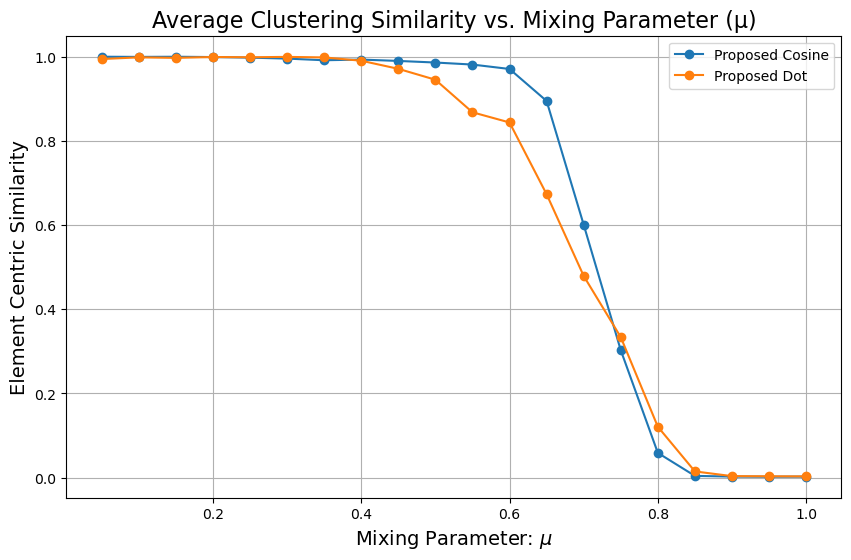

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
plot_dir_data = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/altmeans_clustering_metric_change.txt"
df = pd.read_csv(plot_dir_data)

# Group by `mu` and calculate the mean of `proposed_cosine` and `proposed_dot` over all runs
df_avg = df.groupby('mu')[['proposed_cosine', 'proposed_dot']].mean().reset_index()

# Plot proposed_cosine and proposed_dot vs. mu
plt.figure(figsize=(10, 6))
plt.plot(df_avg['mu'], df_avg['proposed_cosine'], '-o', label='Proposed Cosine')
plt.plot(df_avg['mu'], df_avg['proposed_dot'], '-o', label='Proposed Dot')

# Add labels, title, legend, and grid
plt.xlabel(r'Mixing Parameter: $\mu$', fontsize=14)
plt.ylabel("Element Centric Similarity", fontsize=14)
plt.title("Average Clustering Similarity vs. Mixing Parameter (μ)", fontsize=16)
plt.legend()
plt.grid(True)

# Show and save plot
output_plot = "/nobackup/gogandhi/alt_means_sans_k/results/proposed_similarity_vs_mu.png"
plt.show()


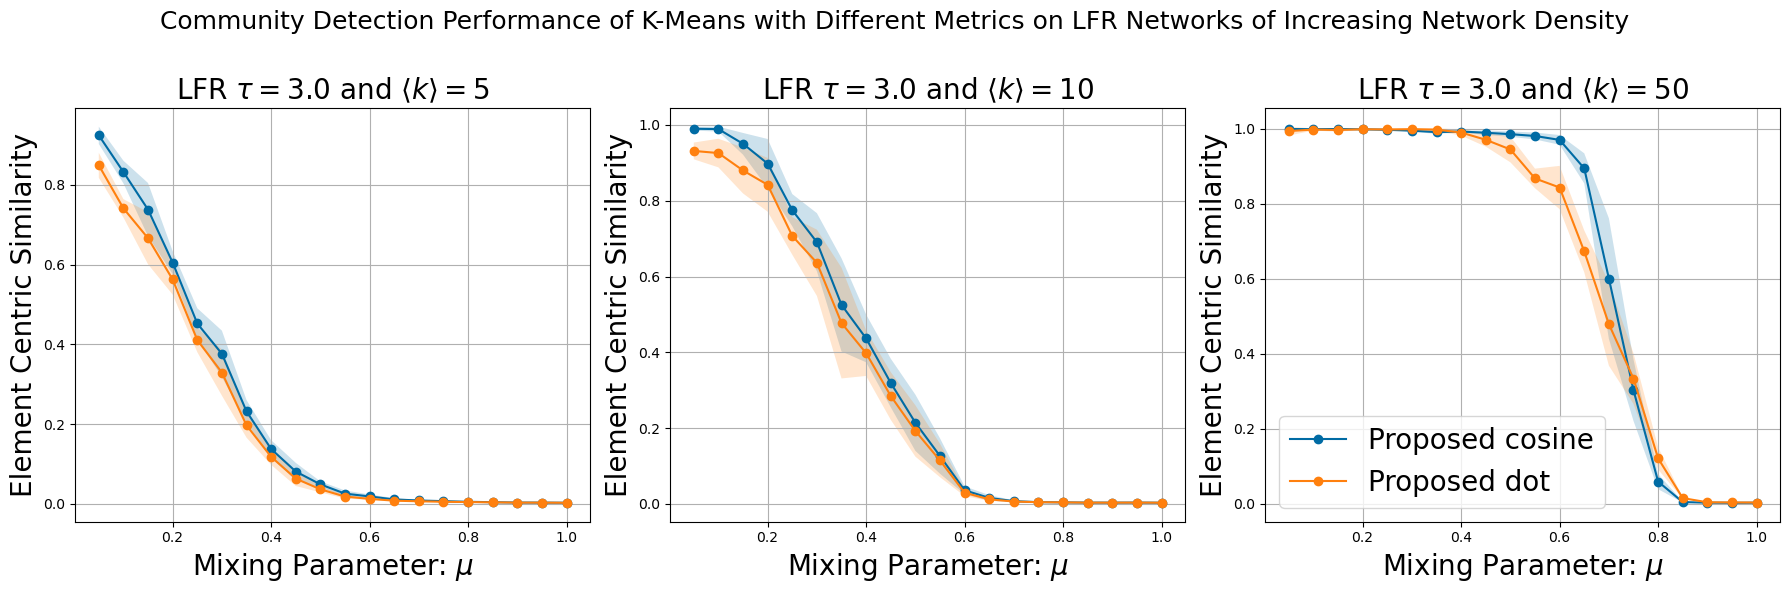

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('tableau-colorblind10')

# Define a dictionary for font sizes
font_sizes = {
    "title": 20,
    "axis_title": 20,
    "axis_label": 20,
    "legend": 20,
    "suptitle": 18,
}

# Define score keys for plotting
score_keys = ['proposed_cosine', 'proposed_dot']

# Load data and compute mean and std for each dimension
df = {}
for dim_key in [5, 10, 50]:  # Replace with actual dimension keys or loop over files
    plot_dir_data = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/altmeans_clustering_metric_change.txt"  # Adjust as needed
    #df[dim_key] = pd.read_csv(plot_dir_data)
    df[dim_key] = pd.read_csv(plot_dir_data).groupby('mu')[score_keys].agg(['mean', 'std']).reset_index()


    
# Create subplots for each dimension (5, 10, and 50)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each DataFrame in `df` and create a subplot
for ax, (dim_key, df_grouped) in zip(axes, df.items()):
    # Plot each score key on the current subplot
    for score_key in score_keys:
        
        
        # Extract mean and std for the current score key
        mean_values = df_grouped[score_key]['mean']
        std_values = df_grouped[score_key]['std']
        
        # Plot mean with standard deviation as shaded area
        ax.plot(df_grouped['mu'], mean_values, '-o', label=score_key.replace('_', ' ').capitalize())
        ax.fill_between(df_grouped['mu'], mean_values - std_values, mean_values + std_values, alpha=0.2)
    
    # Set labels, title, and grid for the subplot
    ax.set_ylabel("Element Centric Similarity", fontsize=font_sizes["axis_title"])
    ax.set_title(rf"LFR $\tau = 3.0$ and $\langle k \rangle = {dim_key}$", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.set_xlabel(r'Mixing Parameter: $\mu$', fontsize=font_sizes["axis_title"])

# Add legend only once, setting font size
axes[-1].legend(loc='lower left', fontsize=font_sizes["legend"])

# Set the figure-level title
fig.suptitle("Community Detection Performance of K-Means with Different Metrics on LFR Networks of Increasing Network Density",
             fontsize=font_sizes["suptitle"])

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle

plt.savefig("/nobackup/gogandhi/alt_means_sans_k/results/Changing clustering metric/changing_altmeans_metric_v1.png")

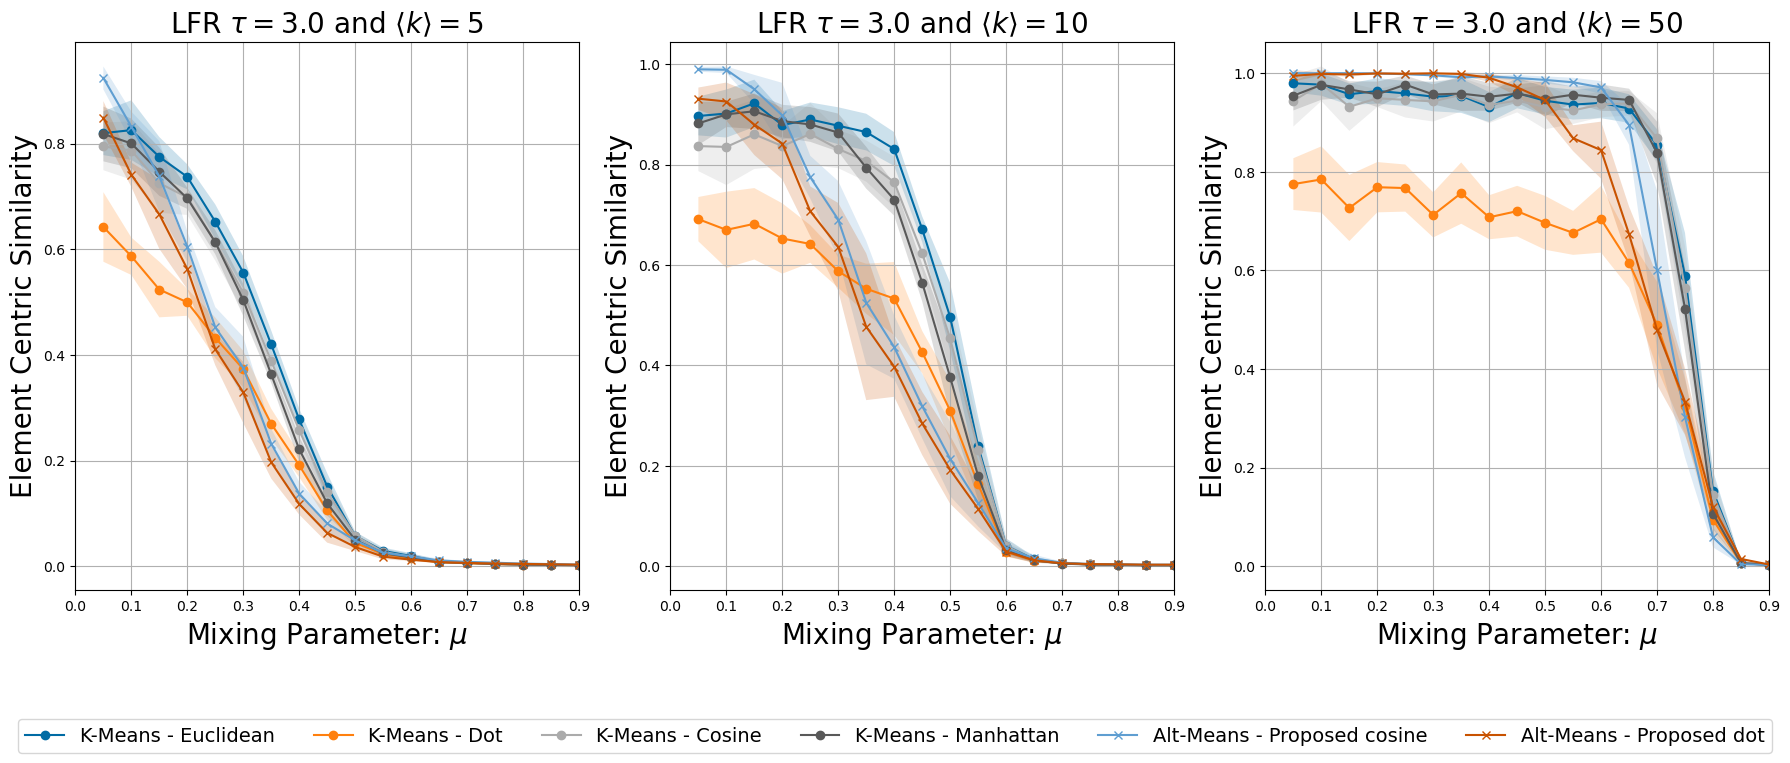

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('tableau-colorblind10')

# Define a dictionary for font sizes
font_sizes = {
    "title": 20,
    "axis_title": 20,
    "axis_label": 20,
    "legend": 15,
}

# Define score keys for plotting
kmeans_score_keys = ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine', 'kmeans_manhattan']
altmeans_score_keys = ['proposed_cosine', 'proposed_dot']

# Load data for K-Means and Alternative Means and compute mean and std for each dimension
df_kmeans = {}
df_altmeans = {}
for dim_key in [5, 10, 50]:
    # Load K-Means data
    kmeans_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/kmeans_clustering_metric_change.txt"
    df_kmeans[dim_key] = pd.read_csv(kmeans_path).groupby('mu')[kmeans_score_keys].agg(['mean', 'std']).reset_index()

    # Load Alternative Means data
    altmeans_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/altmeans_clustering_metric_change.txt"
    df_altmeans[dim_key] = pd.read_csv(altmeans_path).groupby('mu')[altmeans_score_keys].agg(['mean', 'std']).reset_index()

# Create subplots for each dimension (5, 10, and 50)
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Loop through each DataFrame pair for `df_kmeans` and `df_altmeans`, and create combined subplots
for ax, (dim_key, df_kmeans_grouped, df_altmeans_grouped) in zip(axes, zip(df_kmeans.keys(), df_kmeans.values(), df_altmeans.values())):
    # Plot each score key for K-Means on the current subplot
    for score_key in kmeans_score_keys:
        # Extract mean and std for the current score key
        mean_values = df_kmeans_grouped[score_key]['mean']
        std_values = df_kmeans_grouped[score_key]['std']
        
        # Plot mean with standard deviation as shaded area
        ax.plot(df_kmeans_grouped['mu'], mean_values, '-o', label=f"K-Means - {score_key[7:].capitalize()}")
        ax.fill_between(df_kmeans_grouped['mu'], mean_values - std_values, mean_values + std_values, alpha=0.2)

    # Plot each score key for Alternative Means on the current subplot
    for score_key in altmeans_score_keys:
        mean_values = df_altmeans_grouped[score_key]['mean']
        std_values = df_altmeans_grouped[score_key]['std']
        
        # Plot mean with standard deviation as shaded area
        ax.plot(df_altmeans_grouped['mu'], mean_values, '-x', label=f"Alt-Means - {score_key.replace('_', ' ').capitalize()}")
        ax.fill_between(df_altmeans_grouped['mu'], mean_values - std_values, mean_values + std_values, alpha=0.2)

    # Set labels, title, and grid for the subplot
    ax.set_ylabel("Element Centric Similarity", fontsize=font_sizes["axis_title"])
    ax.set_title(rf"LFR $\tau = 3.0$ and $\langle k \rangle = {dim_key}$", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.set_xlabel(r'Mixing Parameter: $\mu$', fontsize=font_sizes["axis_title"])
    ax.set_xlim([0,0.9])
# Add a single legend at the bottom of the figure with font size and arrange labels in one line
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=font_sizes["legend"]-1)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.12, 1, 0.96])  # Adjust layout to fit the legend at the bottom
#output_dir = "/nobackup/gogandhi/alt_means_sans_k/results/Changing clustering metric"
#os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists
#plt.savefig(f"{output_dir}/combined_kmeans_altmeans_metric_across_dimensions.png", dpi=300, bbox_inches='tight')
plt.show()


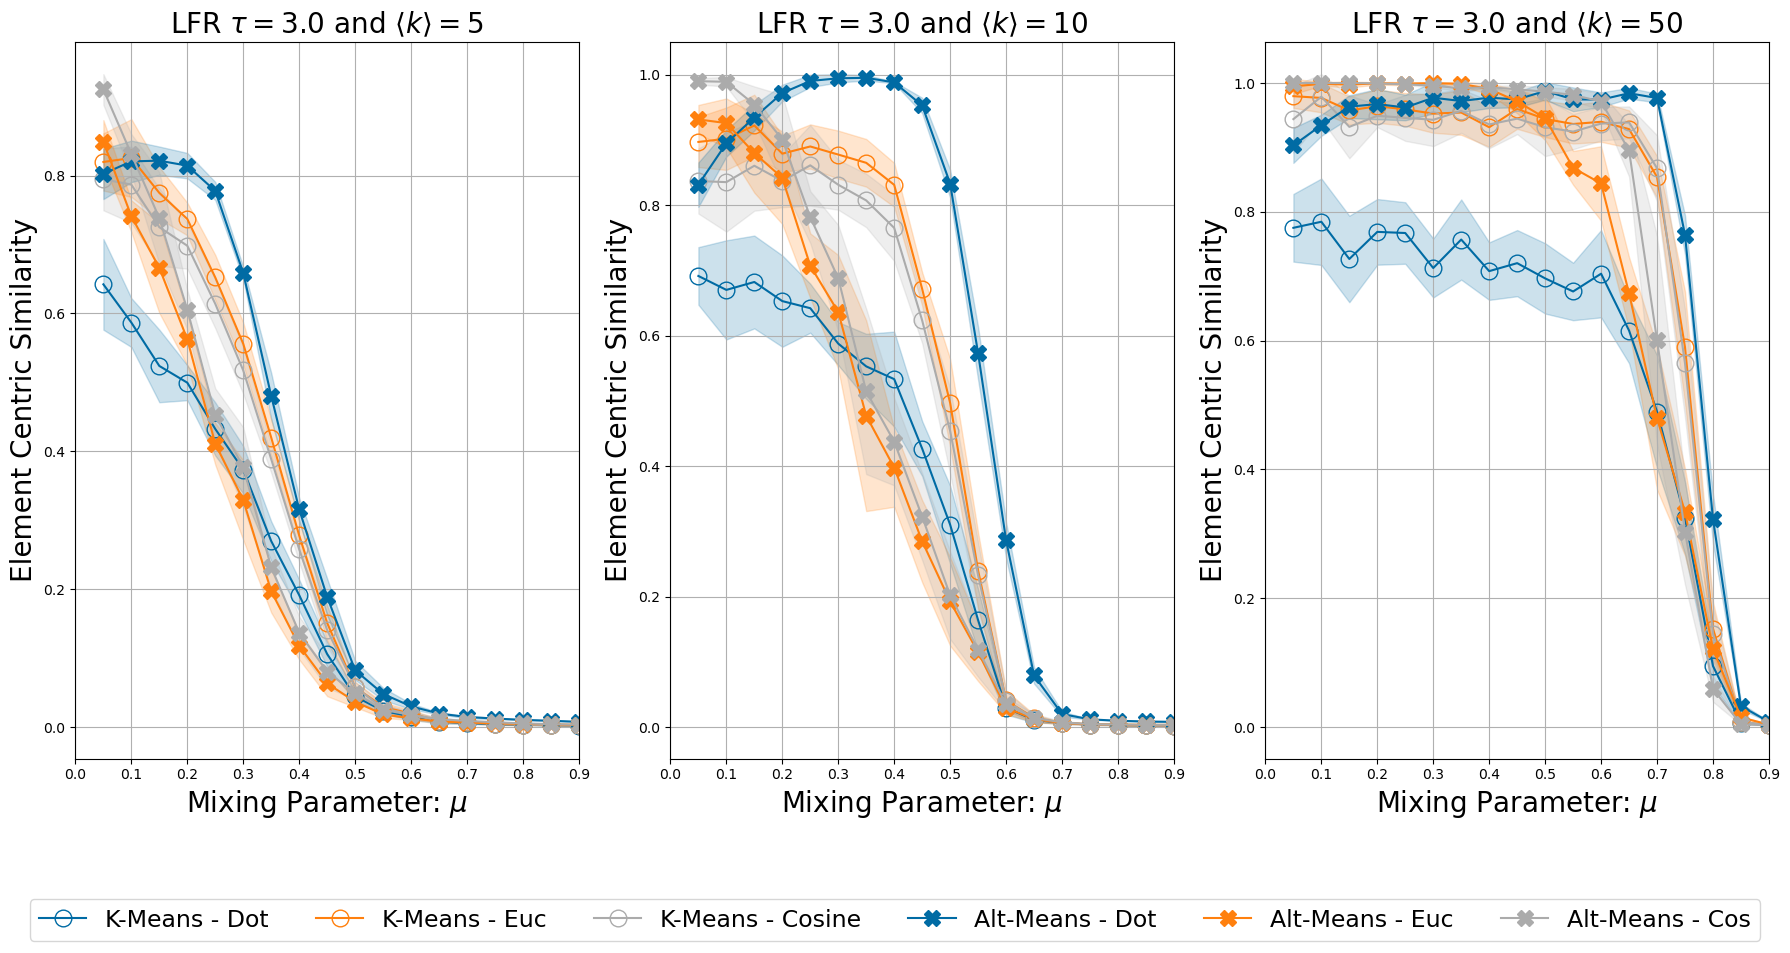

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('tableau-colorblind10')

# Define a dictionary for font sizes
font_sizes = {
    "title": 20,
    "axis_title": 20,
    "axis_label": 20,
    "legend": 18,
}

# Define a marker size variable for easier customization
marker_size = 12  # Customize this as needed

# Define score keys for plotting
kmeans_score_keys = ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']
altmeans_score_keys = ['proposed_cosine', 'proposed_dot']

# Load data for K-Means and Alternative Means and compute mean and std for each dimension
df_kmeans = {}
df_altmeans = {}
for dim_key in [5, 10, 50]:
    # Load K-Means data
    kmeans_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/kmeans_clustering_metric_change.txt"
    df_kmeans[dim_key] = pd.read_csv(kmeans_path).groupby('mu')[kmeans_score_keys].agg(['mean', 'std']).reset_index()

    # Load Alternative Means data
    altmeans_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/altmeans_clustering_metric_change.txt"
    df_altmeans[dim_key] = pd.read_csv(altmeans_path).groupby('mu')[altmeans_score_keys].agg(['mean', 'std']).reset_index()

# Paths for Alt-Means - Euc, Alt-Means - Cosine, and Alt-Means - Dot data
proposed_dot_paths = {
    5: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_5_3.0/result_stream.csv",
    10: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_10_3.0/result_stream.csv",
    50: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0/result_stream.csv"
}

proposed_cosine_paths = {
    5: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_metric_change_10000_5_3.0/result_stream.csv",
    10: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_metric_change_10000_10_3.0/result_stream.csv",
    50: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_metric_change_10000_50_3.0/result_stream.csv"
}

# Colors from tableau-colorblind10
colorblind_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {
    "dot": colorblind_colors[0],      # Dot curves (blue)
    "euc": colorblind_colors[1],      # Euc curves (orange)
    "cosine": colorblind_colors[2]    # Cosine curves (green)
}

# Distinct and prominent markers for each curve type
markers = {
    "kmeans_dot": "o",         # Circle for K-Means Dot
    "altmeans_dot": "X",       # Diamond for Alt-Means Dot
    "kmeans_euc": "o",         # Square for K-Means Euclidean
    "altmeans_euc": "X",       # Filled Plus for Alt-Means Euc
    "kmeans_cosine": "o",      # Triangle for K-Means Cosine
    "altmeans_cosine": "X"     # Cross for Alt-Means Cosine
}

# Create subplots for each dimension (5, 10, and 50)
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Loop through each DataFrame pair for `df_kmeans` and `df_altmeans`, and create combined subplots
for ax, (dim_key, df_kmeans_grouped, df_altmeans_grouped) in zip(axes, zip(df_kmeans.keys(), df_kmeans.values(), df_altmeans.values())):
    # Plot each K-Means curve with the specified colors, markers, and markerfacecolor
    for score_key, color, marker, label_suffix in zip(
        ['kmeans_dot', 'kmeans_euclidean', 'kmeans_cosine'],
        [colors['dot'], colors['euc'], colors['cosine']],
        [markers['kmeans_dot'], markers['kmeans_euc'], markers['kmeans_cosine']],
        ['Dot', 'Euc', 'Cosine']
    ):
        mean_values = df_kmeans_grouped[score_key]['mean']
        std_values = df_kmeans_grouped[score_key]['std']
        
        # Set markerfacecolor to None for K-Means Dot
        markerfacecolor = 'none' if marker == 'o' else color
        
        ax.plot(df_kmeans_grouped['mu'], mean_values, marker=marker, color=color, label=f"K-Means - {label_suffix}",
                markersize=marker_size, markerfacecolor=markerfacecolor)
        ax.fill_between(df_kmeans_grouped['mu'], mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

    # Plot Alt-Means - Dot, Alt-Means - Euc (renamed from proposed_dot), and Alt-Means - Cosine
    # Load Alt-Means - Dot
    proposed_dot_df = pd.read_csv(proposed_dot_paths[dim_key])
    proposed_dot_grouped = proposed_dot_df.groupby('mu')['proposed'].agg(['mean', 'std']).reset_index()
    ax.plot(proposed_dot_grouped['mu'], proposed_dot_grouped['mean'], marker=markers['altmeans_dot'], color=colors['dot'], 
            label="Alt-Means - Dot", markersize=marker_size)
    ax.fill_between(proposed_dot_grouped['mu'], proposed_dot_grouped['mean'] - proposed_dot_grouped['std'], 
                    proposed_dot_grouped['mean'] + proposed_dot_grouped['std'], color=colors['dot'], alpha=0.2)
    
    # Alt-Means - Euc
    mean_values = df_altmeans_grouped['proposed_dot']['mean']
    std_values = df_altmeans_grouped['proposed_dot']['std']
    ax.plot(df_altmeans_grouped['mu'], mean_values, marker=markers['altmeans_euc'], color=colors['euc'], 
            label="Alt-Means - Euc", markersize=marker_size)
    ax.fill_between(df_altmeans_grouped['mu'], mean_values - std_values, mean_values + std_values, color=colors['euc'], alpha=0.2)

    # Alt-Means - Cosine
    proposed_cosine_df = pd.read_csv(proposed_cosine_paths[dim_key])
    proposed_cosine_grouped = proposed_cosine_df.groupby('mu')['proposed'].agg(['mean', 'std']).reset_index()
    ax.plot(proposed_cosine_grouped['mu'], proposed_cosine_grouped['mean'], marker=markers['altmeans_cosine'], color=colors['cosine'], 
            label="Alt-Means - Cos", markersize=marker_size)
    ax.fill_between(proposed_cosine_grouped['mu'], proposed_cosine_grouped['mean'] - proposed_cosine_grouped['std'], 
                    proposed_cosine_grouped['mean'] + proposed_cosine_grouped['std'], color=colors['cosine'], alpha=0.2)

    # Set labels, title, and grid for the subplot
    ax.set_ylabel("Element Centric Similarity", fontsize=font_sizes["axis_title"])
    ax.set_title(rf"LFR $\tau = 3.0$ and $\langle k \rangle = {dim_key}$", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.set_xlabel(r'Mixing Parameter: $\mu$', fontsize=font_sizes["axis_title"])
    ax.set_xlim([0, 0.9])

# Add a single legend at the bottom of the figure with font size and arrange labels in one line
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=font_sizes["legend"]-1)

# Adjust layout and show the figure
plt.tight_layout(rect=[0, 0.12, 1, 0.96])  # Adjust layout to fit the legend at the bottom
plt.savefig("/nobackup/gogandhi/alt_means_sans_k/results/Changing clustering metric/alt_means_metric_change.png",dpi=300,bbox_inches='tight')
plt.show()


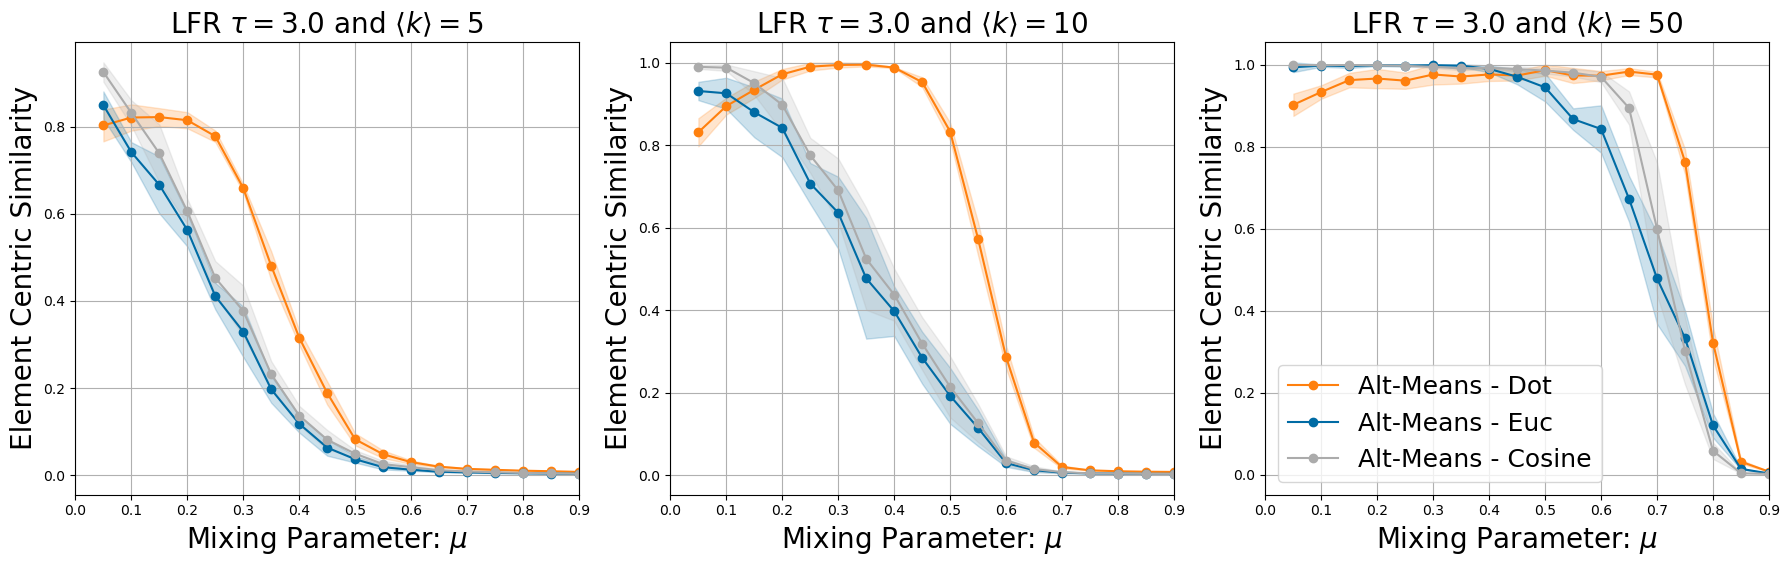

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('tableau-colorblind10')

# Define font sizes for consistent styling
font_sizes = {
    "title": 20,
    "axis_title": 20,
    "axis_label": 20,
    "legend": 18,
}

# Define marker size
marker_size = 10  # Uniform marker size for consistency with the reference

# Load Alt-Means data and group by `mu` for each dimension
df_altmeans = {}
for dim_key in [5, 10, 50]:
    altmeans_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/altmeans_clustering_metric_change.txt"
    df_altmeans[dim_key] = pd.read_csv(altmeans_path).groupby('mu')[['proposed_cosine', 'proposed_dot']].agg(['mean', 'std']).reset_index()

# Paths for additional Alt-Means Cosine and Dot data
proposed_dot_paths = {
    5: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_5_3.0/result_stream.csv",
    10: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_10_3.0/result_stream.csv",
    50: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0/result_stream.csv"
}

proposed_cosine_paths = {
    5: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_metric_change_10000_5_3.0/result_stream.csv",
    10: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_metric_change_10000_10_3.0/result_stream.csv",
    50: f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_metric_change_10000_50_3.0/result_stream.csv"
}

# Define colors and markers for Alt-Means curves
colorblind_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {
    "dot": colorblind_colors[1],      # Dot (blue)
    "euc": colorblind_colors[0],      # Euc (orange)
    "cosine": colorblind_colors[2]    # Cosine (green)
}

# Unified marker style to match reference plot
marker_style = 'o'  # Circle markers for all curves for consistent style

# Create subplots for each dimension (5, 10, and 50)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each DataFrame pair in `df_altmeans` for plotting
for ax, (dim_key, df_altmeans_grouped) in zip(axes, df_altmeans.items()):
    # Plot Alt-Means - Dot
    proposed_dot_df = pd.read_csv(proposed_dot_paths[dim_key])
    proposed_dot_grouped = proposed_dot_df.groupby('mu')['proposed'].agg(['mean', 'std']).reset_index()
    ax.plot(proposed_dot_grouped['mu'], proposed_dot_grouped['mean'], marker=marker_style, color=colors['dot'], 
            label="Alt-Means - Dot",  linestyle='-')
    ax.fill_between(proposed_dot_grouped['mu'], proposed_dot_grouped['mean'] - proposed_dot_grouped['std'], 
                    proposed_dot_grouped['mean'] + proposed_dot_grouped['std'], color=colors['dot'], alpha=0.2)
    
    # Plot Alt-Means - Euc
    mean_values = df_altmeans_grouped['proposed_dot']['mean']
    std_values = df_altmeans_grouped['proposed_dot']['std']
    ax.plot(df_altmeans_grouped['mu'], mean_values, marker=marker_style, color=colors['euc'], 
            label="Alt-Means - Euc", linestyle='-')
    ax.fill_between(df_altmeans_grouped['mu'], mean_values - std_values, mean_values + std_values, color=colors['euc'], alpha=0.2)

    # Plot Alt-Means - Cosine
    proposed_cosine_df = pd.read_csv(proposed_cosine_paths[dim_key])
    proposed_cosine_grouped = proposed_cosine_df.groupby('mu')['proposed'].agg(['mean', 'std']).reset_index()
    ax.plot(proposed_cosine_grouped['mu'], proposed_cosine_grouped['mean'], marker=marker_style, color=colors['cosine'], 
            label="Alt-Means - Cosine",  linestyle='-')
    ax.fill_between(proposed_cosine_grouped['mu'], proposed_cosine_grouped['mean'] - proposed_cosine_grouped['std'], 
                    proposed_cosine_grouped['mean'] + proposed_cosine_grouped['std'], color=colors['cosine'], alpha=0.2)

    # Set labels, title, and grid for the subplot
    ax.set_ylabel("Element Centric Similarity", fontsize=font_sizes["axis_title"])
    ax.set_title(rf"LFR $\tau = 3.0$ and $\langle k \rangle = {dim_key}$", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.set_xlabel(r'Mixing Parameter: $\mu$', fontsize=font_sizes["axis_title"])
    ax.set_xlim([0, 0.9])

# Place legend in the rightmost subplot only
axes[-1].legend(loc='lower left', fontsize=font_sizes["legend"])

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap
plt.savefig("/nobackup/gogandhi/alt_means_sans_k/results/Changing clustering metric/only_alt_means_metric_change.png", dpi=300, bbox_inches='tight')
plt.show()
